In [84]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [39]:
#3 задание
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.groupby('room_type',as_index=False).quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


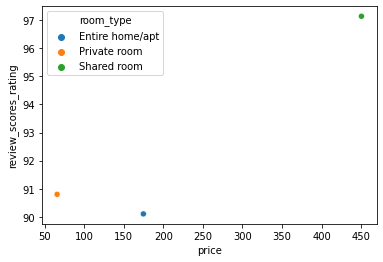

In [53]:
#4 задание
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM ldn_listings
WHERE review_scores_rating IS NOT NULL
ORDER BY id DESC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
grouped_df=df.groupby('room_type',as_index=False).agg({'price':'mean','review_scores_rating':'mean'})
sns.scatterplot(data=grouped_df,x='price',y='review_scores_rating', hue='room_type')

In [65]:
#5 задание
query = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df["host_verifications"]=df["host_verifications"].apply(lambda x: x.strip("[]").replace("'", "").split(", "))
df.explode('host_verifications').value_counts('host_verifications')

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
dtype: int64

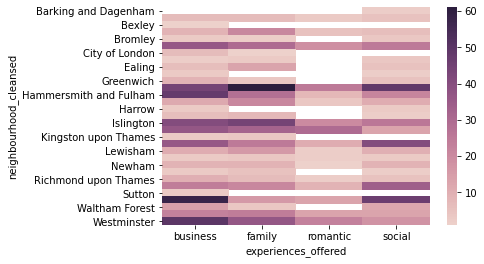

In [77]:
#6 задание
query = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) as experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
new_df=df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
sns.heatmap(new_df,cmap=sns.cubehelix_palette(as_cmap=True))

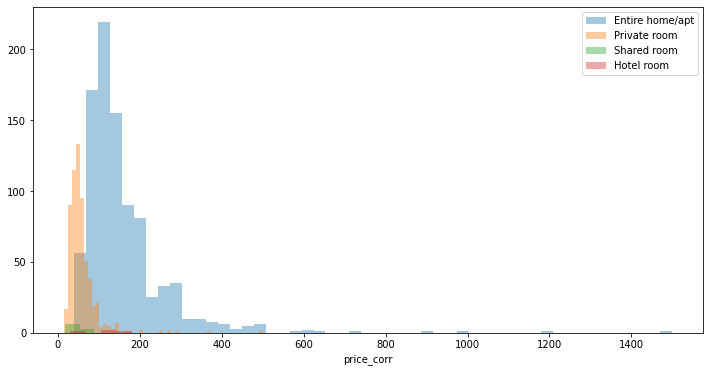

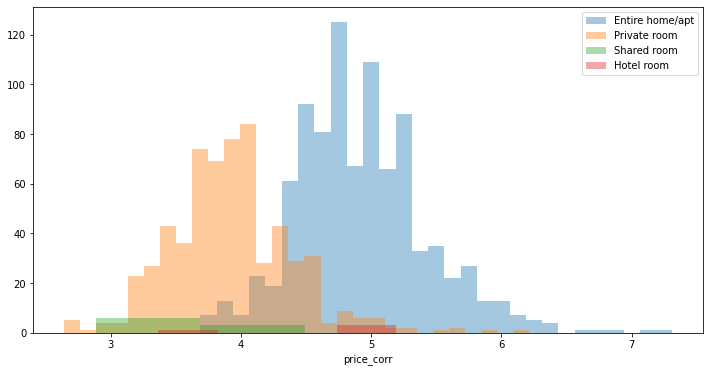

In [95]:
#7 задание
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
plt.figure(figsize=(12, 6))
sns.distplot(df.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')
sns.distplot(df.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')
plt.legend()
plt.show()

In [115]:
#8 задание
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
    first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df["first_review"]=df["first_review"].apply(lambda x: x[:-6])
df_for_line=df.groupby(["room_type","first_review"]).agg({'price_corr':'mean'}).reset_index().sort_values('first_review',ascending=True)
df_for_line

,room_type,first_review,price_corr
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143
2,Entire home/apt,2012,135.467255
15,Private room,2012,53.269840
24,Shared room,2012,22.000000
3,Entire home/apt,2013,137.887634
16,Private room,2013,57.036587


In [111]:
df

,room_type,price_corr,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [ ]:
#выгружаем данные из pandas в excel
df.to_excel("./ch_data.xlsx", sheet_name='Data', index=False, encoding='UTF-8')

In [ ]:
#читаем данные из csv в pandas
df_in = pd.read_csv("./medium.csv", sep='\t')
df_in

In [ ]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query_create = """
CREATE TABLE test.beslan_import_test (
    published String,
    domain String,
    url String
)
ENGINE = Log
"""
df_create = ph.read_clickhouse(query_create, connection=connection)
df_create

In [ ]:
#записываем данные из pandas в clickhouse
ph.to_clickhouse(df_in, 'beslan_import_test', index=False, connection=connection)

In [ ]:
#проверяем, что записалось
query_test = """
SELECT *
FROM test.beslan_import_test
"""
df_new = ph.read_clickhouse(query_test, connection=connection)
df_new